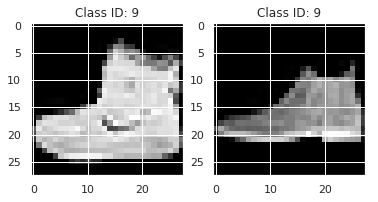

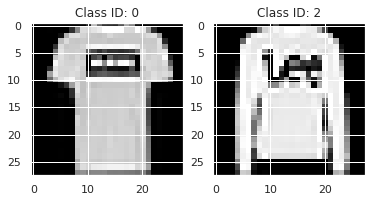

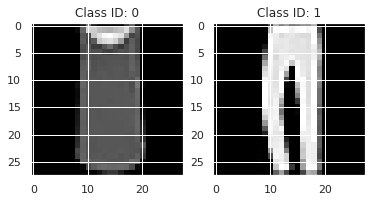

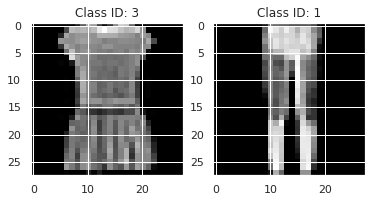

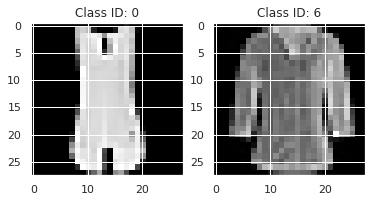

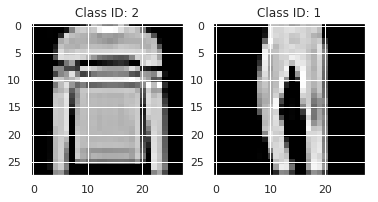

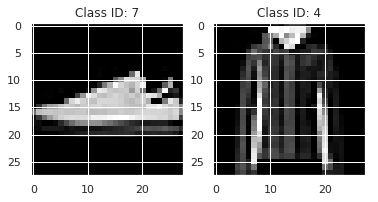

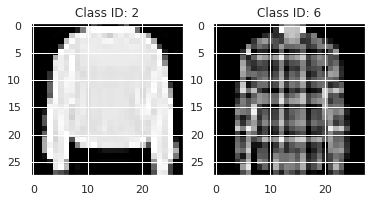

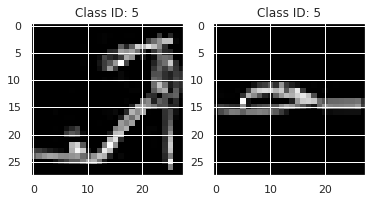

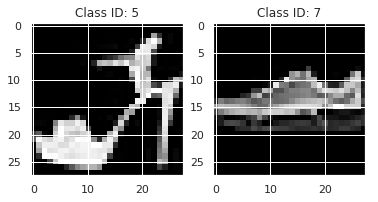

('Original label             :', 9)
('After conversion to one-hot encoded:', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
dense_31 (Dense)             (None, 28, 28, 32)        1056      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
dense_32 (Dense)             (None, 28, 28, 32)        2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 64)        18496     
_

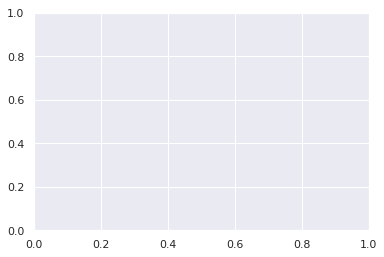

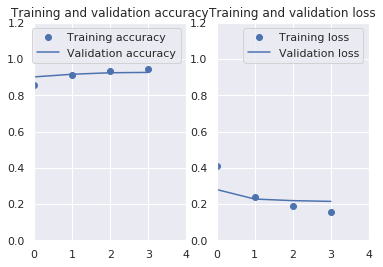

Found 9208 correct labels
Found 792 incorrect labels


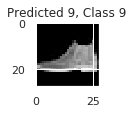

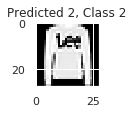

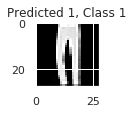

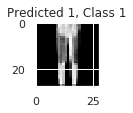

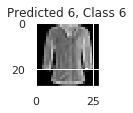

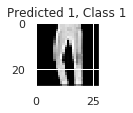

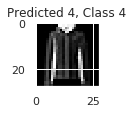

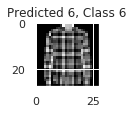

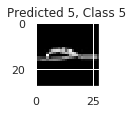

<Figure size 432x288 with 0 Axes>

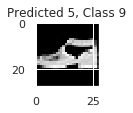

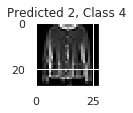

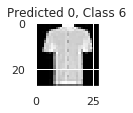

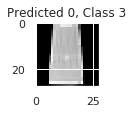

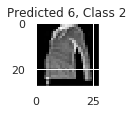

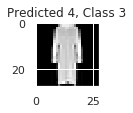

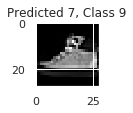

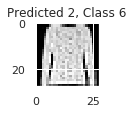

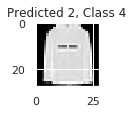

<Figure size 432x288 with 0 Axes>

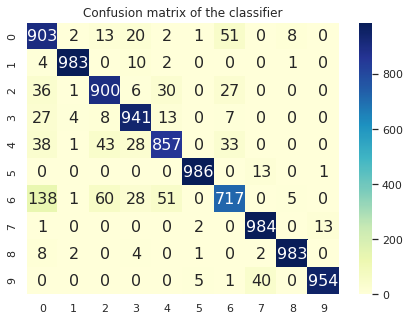

In [0]:
try:
    import h5py
except ImportError:
    h5py = None
from keras.datasets import fashion_mnist
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import random
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
random.seed(0)

def show_results(nn_model_train): # plot performance over the training epochs
    accuracy     = nn_model_train.history['acc']
    val_accuracy = nn_model_train.history['val_acc']
    loss         = nn_model_train.history['loss']
    val_loss     = nn_model_train.history['val_loss']
    epochs       = range(len(accuracy))
    nb_epochs    = len(epochs)

    plt.subplot(1,2,1)
    plt.axis((0,nb_epochs,0,1.2))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.axis((0,nb_epochs,0,1.2))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.draw()
    plt.savefig('Accuracylossovertime.png') #Adil update
    plt.pause(0.001)

def predict_and_visualize_results(model, input_X, output_Y):
    predicted_classes = model.predict(input_X) # Computes for every image in the test dataset
                                              # a probability distribution over the 10 categories
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1) # Choose the prediction with the highest probability
    correctIndex = np.where(predicted_classes==output_Y)[0]
    incorrectIndex = np.where(predicted_classes!=output_Y)[0]
    print("Found %d correct labels" % len(correctIndex))
    print("Found %d incorrect labels" % len(incorrectIndex))

    # show the some correctly predicted categories
    f3 = plt.figure(3)
    for i, correct in enumerate(correctIndex[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(test_X[correct].reshape(28,28), cmap='gray')
        plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
        plt.draw()
        plt.pause(0.001)
    plt.tight_layout()
    plt.pause(0.001)

    # show the some incorrectly predicted categories
    f4 = plt.figure(4)
    for i, incorrect in enumerate(incorrectIndex[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
        plt.draw()
        plt.pause(0.001)
    plt.tight_layout()
    plt.pause(0.001)

    cm=confusion_matrix(test_Y,predicted_classes)
    df_cm= pd.DataFrame(cm,columns=np.unique(test_Y),index=np.unique(predicted_classes))
    fig = plt.figure(figsize=(7,5))
    plt.title('Confusion matrix of the classifier')
    sns.set(font_scale=1)
    sns.heatmap(df_cm, cmap="YlGnBu",annot=True, annot_kws={"size":16},fmt='d')
    plt.show()

## -- Load the Data -- ##
# Label	Description example
#   0	T-shirt/top
#   1	Trouser
#   2	Pullover
#   3	Dress
#   .	.
#   .	.
#   .	.

# -- Get Training+Validation Set & Test Set from dataset -- ##
(trainAndVal_X,trainAndVal_Y), (test_X,test_Y) = fashion_mnist.load_data()
classes  = np.unique(trainAndVal_Y)
nClasses = len(classes)

#---------------------------------------------------------------------------------
#------------------------------ PROBLEM 0: testing -------------------------------
#---------------------------------------------------------------------------------
## -- Display images from training data and test data -- ##
if True: # Set it to "False" if you don't want to see the image display
    f1 = plt.figure(1)
    for i in range(10):
        plt.subplot(1,2,1)
        plt.ion()
        plt.imshow(trainAndVal_X[i,:,:], cmap='gray')
        plt.title("Class ID: {}".format(trainAndVal_Y[i]))

        plt.subplot(1,2,2)
        plt.ion()
        plt.imshow(test_X[i,:,:], cmap='gray')
        plt.title("Class ID: {}".format(test_Y[i]))
        plt.show()
        plt.pause(1)
        plt.cla()
#---------------------------------------------------------------------------------
#-------------------------------- PROBLEM 0: end ---------------------------------
#---------------------------------------------------------------------------------

imgPixelDim = 28 # image pixel dimension

## -- Reshape the images to match the NN input format  -- ##
trainAndVal_X = trainAndVal_X.reshape(-1, imgPixelDim, imgPixelDim, 1) # nb of images: -1 for automatically assigned; pixels: imgPixelDim x imgPixelDim ; nb of channels: 1 for grey scale, 3 for RGB
test_X        = test_X.reshape( -1, imgPixelDim, imgPixelDim, 1)

## -- Convert data type from int8 to float32 -- ##
trainAndVal_X = trainAndVal_X.astype('float32')
test_X = test_X.astype('float32')

## -- Normalize the dtata: rescale the pixel values in range 0 - 1 inclusive for training purposes -- ##
trainAndVal_X = trainAndVal_X / 255.
test_X = test_X / 255.

## -- Change the labels from categorical to one-hot encoding -- ##
# Example: image label 7 becomes [0 0 0 0 0 0 0 1 0] ; The output neurons of the NN will be trained to match the one_hot encoded array
trainAndVal_Y_one_hot = to_categorical(trainAndVal_Y)
test_Y_one_hot  = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label             :', trainAndVal_Y[0])
print('After conversion to one-hot encoded:', trainAndVal_Y_one_hot[0])

## -- Split the trainAndVal data into training dataset and validation dataset -- ##
# The moodel is trained over the training dataset
# The validation dataset is used to monitor when the model starts overfitting on the training dataset
train_X,valid_X,train_label,valid_label = train_test_split(trainAndVal_X, trainAndVal_Y_one_hot, test_size=0.2, random_state=13)

#---------------------------------------------------------------------------------
#------------------------------------ PROBLEM ------------------------------------
#---------------------------------------------------------------------------------
if True:
    #------------------------------Hyper Parameters-----------------------------------
    batch_size  = 64   # how many images with their corresponding cotegories to use per
    # per NN weights update step
    epochs      = 4   # how many times to loop over the entire training dataset
    # example: for a batch_size=64 and training dataset size of 48000
    # then each epoch will consist of 48000/64=750 updates of the network weights
    learning_rate = 0.001

    model = Sequential()

    #------------------------------------Architecture---------------------------------
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(Dense(32, activation='relu'))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.05))

    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same'))
    model.add(Dense(32, activation='relu'))

    model.add(MaxPooling2D((2, 2),padding='same'))

    model.add(Flatten())
    #---------------------------------------------------------------------------------
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(nClasses, activation='softmax'))

    model.summary()

    #------------------------------Optimizer-----------------------------------
    opt = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])  # Classification accuracy is the number of correct predictions made divided by the
                                                                                                    # total number of predictions made, multiplied by 100 to turn it into a percentage


#---------------------------------------------------------------------------------
#---------------------------------- PROBLEM ---- ---------------------------------
#---------------------------------------------------------------------------------

############################################################
## -- Test the performmance of the untrained model over the test dataset -- ##
predicted_classes = model.predict(test_X) # Computes for every image in the test dataset
                                                  # a probability distribution over the 10 categories
predicted_classes = np.argmax(np.round(predicted_classes),axis=1) # Choose the prediction with the highest probability

correctIndex = np.where(predicted_classes==test_Y)[0]
incorrectIndex = np.where(predicted_classes!=test_Y)[0]
print("Found %d correct labels using the untrained model" % len(correctIndex))
print("Found %d incorrect labels using the untrained model" % len(incorrectIndex))

## -- Train the Neural Network -- ##
start_time = time.time()
fashion_train_dropout = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
trainTime = (time.time() - start_time)
print('Training time = {}'.format(trainTime))

## -- Test the performmance of the trained model over the test dataset -- ##
test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])      # this is the categorical_crossentropy
print('Test accuracy:', test_eval[1])  # the accuracy evaluated by the model during training and testing

show_results(fashion_train_dropout)

predict_and_visualize_results(model, test_X, test_Y)
